In [1]:
"""

--- virtualenv = torch_env ---

We are trying to create a multiclass classification model for hand gesture
detection. there are altogether 8 gestures labelled from 0-7 which are used to control 
the  tello drone ultimately.

"""

import torch
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


#setting up device agnostic code
device="cuda" if torch.cuda.is_available() else "cpu"

print(f"device is: {device}")

# pre-processed landmarks self-made dataset
# url='https://raw.githubusercontent.com/Bikash9841/gestureD/main/keypoint.csv'


# this is from github dataset but for 8 gestures
url='https://media.githubusercontent.com/media/kinivi/tello-gesture-control/main/model/keypoint_classifier/keypoint.csv'

df=pd.read_csv(url)


device is: cpu


shape of dataframe: (6189, 43)
features: (6189, 42) labels: (6189,)
[1594 1663 1510  672  164  257  139  190]


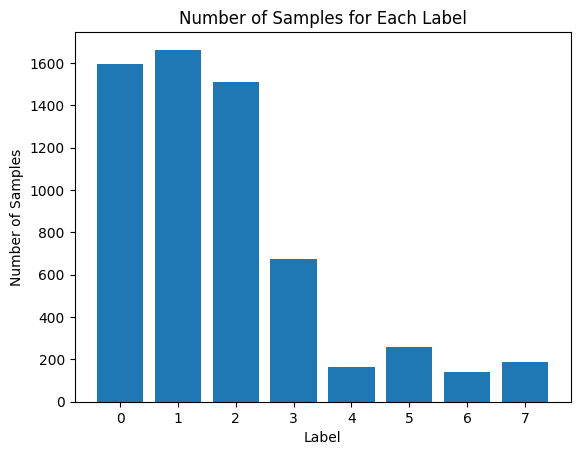

In [2]:

df=shuffle(df,random_state=42)
print(f"shape of dataframe: {df.shape}")

'''
# extracting features from self-made dataset
X=df.iloc[:,:42].values
y=df.iloc[:,42].values
'''

# for github's 8 dataset
req_df=df.iloc[:,1:]
X=req_df.values
y=df.iloc[:,0].values



print(f"features: {X.shape} labels: {y.shape}")

# turning data into tensors
X=torch.from_numpy(X).type(torch.float).to(device)
y=torch.from_numpy(y).type(torch.LongTensor).to(device)


# visualizing dataset

# Count the number of samples for each label
label_counts = np.bincount(y)
print(label_counts)

# Plotting the bar plot
plt.bar(range(len(label_counts)), label_counts, tick_label=range(len(label_counts)))
plt.title('Number of Samples for Each Label')
plt.xlabel('Label')
plt.ylabel('Number of Samples')
plt.show()


In [3]:
# splitting dataset into train and test set
from sklearn.model_selection import train_test_split
from torch import nn

X_train,X_test,y_train,y_test=train_test_split(X,
    y,
    test_size=0.2,
    random_state=42)

print(f"train set: {X_train.shape}, test set: {X_test.shape} ,train/test labels: {y_train.shape},{y_test.shape}")


class GestureModel(nn.Module):
  def __init__(self,input_features,output_features,hidden_units=16):

    super().__init__()
    self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )
    
  def forward(self, x):
    return self.linear_layer_stack(x)

# create a instance of model and send it to the target device
model_1=GestureModel(42,8).to(device)

model_1



train set: torch.Size([4951, 42]), test set: torch.Size([1238, 42]) ,train/test labels: torch.Size([4951]),torch.Size([1238])


GestureModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=42, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=16, bias=True)
    (7): ReLU()
    (8): Linear(in_features=16, out_features=8, bias=True)
  )
)

In [4]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_1.parameters(), 
                            lr=0.1)

# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
model_1(X_train)[:5]


tensor([[ 0.0668, -0.0312, -0.1862,  0.0319,  0.1422,  0.1685, -0.1980,  0.1607],
        [ 0.0630, -0.0297, -0.1813,  0.0318,  0.1436,  0.1705, -0.1987,  0.1634],
        [ 0.0697, -0.0385, -0.1919,  0.0346,  0.1495,  0.1734, -0.1931,  0.1676],
        [ 0.0691, -0.0277, -0.1857,  0.0253,  0.1370,  0.1671, -0.1948,  0.1639],
        [ 0.0663, -0.0265, -0.1833,  0.0297,  0.1380,  0.1693, -0.1988,  0.1638]],
       grad_fn=<SliceBackward0>)

In [5]:
# Make prediction logits with model without actually training just to see the working of softmax 
y_logits = model_1(X_test)

print(y_logits)
# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1) 

# print(y_logits[:5])
# print(y_pred_probs[:5])


# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])

# just select the largest probabilities among 8 classses of 0th index.
print(torch.argmax(y_pred_probs[0]))



tensor([[ 0.0629, -0.0289, -0.1828,  ...,  0.1672, -0.1992,  0.1614],
        [ 0.0708, -0.0331, -0.1910,  ...,  0.1696, -0.1951,  0.1630],
        [ 0.0669, -0.0274, -0.1842,  ...,  0.1690, -0.1972,  0.1640],
        ...,
        [ 0.0520, -0.0326, -0.1748,  ...,  0.1687, -0.2010,  0.1609],
        [ 0.0677, -0.0332, -0.1873,  ...,  0.1730, -0.1958,  0.1685],
        [ 0.0509, -0.0307, -0.1711,  ...,  0.1714, -0.2018,  0.1604]],
       grad_fn=<AddmmBackward0>)
tensor([0.1294, 0.1181, 0.1012, 0.1253, 0.1400, 0.1436, 0.0996, 0.1428],
       grad_fn=<SelectBackward0>)
tensor(5)


-----------------------------------------LETS TRAIN OUR MODEL NOW.


In [6]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [7]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 1000

for epoch in range(epochs):
    ### Training
    model_1.train()

    # 1. Forward pass
    y_logits = model_1(X_train) # model outputs raw logits 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) 
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_1(X_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 2.13109, Acc: 4.38% | Test Loss: 2.11126, Test Acc: 3.23%
Epoch: 10 | Loss: 1.98494, Acc: 26.06% | Test Loss: 1.97139, Test Acc: 26.58%
Epoch: 20 | Loss: 1.87586, Acc: 26.94% | Test Loss: 1.86681, Test Acc: 26.58%
Epoch: 30 | Loss: 1.79804, Acc: 26.94% | Test Loss: 1.79303, Test Acc: 26.58%
Epoch: 40 | Loss: 1.75039, Acc: 26.94% | Test Loss: 1.74828, Test Acc: 26.58%
Epoch: 50 | Loss: 1.72568, Acc: 26.94% | Test Loss: 1.72472, Test Acc: 26.58%
Epoch: 60 | Loss: 1.71344, Acc: 26.94% | Test Loss: 1.71257, Test Acc: 26.58%
Epoch: 70 | Loss: 1.70703, Acc: 26.94% | Test Loss: 1.70583, Test Acc: 26.58%
Epoch: 80 | Loss: 1.70307, Acc: 26.94% | Test Loss: 1.70157, Test Acc: 26.58%
Epoch: 90 | Loss: 1.70013, Acc: 26.94% | Test Loss: 1.69843, Test Acc: 26.58%
Epoch: 100 | Loss: 1.69761, Acc: 26.94% | Test Loss: 1.69582, Test Acc: 26.58%
Epoch: 110 | Loss: 1.69519, Acc: 26.94% | Test Loss: 1.69336, Test Acc: 26.58%
Epoch: 120 | Loss: 1.69264, Acc: 26.94% | Test Loss: 1.69082, Tes

In [8]:
from sklearn.metrics import f1_score

# Make predictions
model_1.eval()
with torch.inference_mode():
    y_logits = model_1(X_test)

# View the first 10 predictions
y_logits[10:20]


# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# f1 = F1Score(task="multiclass", num_classes=8)

print(f"f1 score: {f1_score(y_test,y_preds,average='macro')}")


# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[10:20]}\nLabels: {y_test[10:20]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_test, y_pred=y_preds)}%")

f1 score: 0.951414381556589
Predictions: tensor([7, 0, 0, 2, 1, 0, 1, 1, 2, 1])
Labels: tensor([7, 0, 0, 2, 1, 0, 1, 1, 2, 1])
Test accuracy: 96.52665589660742%


In [ ]:
# Saving the model

# saving and loading a trained model
# from pathlib import Path

# # 1. create models directory
# MODEL_PATH=Path("models")
# MODEL_PATH.mkdir(parents=True,exist_ok=True)

# 2. create model save path
# MODEL_NAME="01_gesture_detection.pth"
# MODEL_SAVE_PATH=MODEL_PATH / MODEL_NAME

# # 3. save the model state dict

# print(f"Saving model to: {MODEL_SAVE_PATH}")
# torch.save(obj=model_1.state_dict(),f=MODEL_SAVE_PATH)

In [9]:


# -------------------------- NEXT TIME YOU CAN START FROM HERE BY LOADING THE MODEL DIRECTLY-----------------


# load a pytorch model

# create a new instace of linear regression model V2

# loaded_GestureModel_1=GestureModel(42,8)

# # load the saved model state_dict
# loaded_GestureModel_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# # put the loaded model to device
# loaded_GestureModel_1.to(device)

def detectGes(X, orgX, orgY):
  # print(X.shape)
  # processing data to make it like the data we train on
  # print(X)

  for id, cood in enumerate(X[0]):
    if (id % 2 == 0):
      # X[0][id]=torch.round((cood-orgX),decimals=3)
      X[0][id] = (cood-orgX)
    else:
      # X[0][id]=torch.round((cood-orgY),decimals=3)
      X[0][id] = (cood-orgY)

  # print(X)

  maxVal=abs(X[0][0])
  for val in X[0]:
    if(abs(val)>abs(maxVal)):
      maxVal=val
  
  # print(maxVal)
  
  # for id,cood in enumerate(X[0]):
  #   X[0][id]=torch.round((X[0][id]/abs(maxVal)),decimals=3)
  
  # X[0]=torch.round(X[0]/abs(maxVal),decimals=3)
  X[0]=X[0]/abs(maxVal)
  # print(maxVal)
  # print(X)

  return torch.softmax(model_1(X), dim=1).argmax(dim=1)


In [ ]:

def preprocess(data):
    # first make all landmarks coordinate relative to zero
    # then normalize it to the maximum value
    # print(data)
    for i in range(len(data)):
        orgX = data[i][0]
        orgY = data[i][1]
        for id, cood in enumerate(data[i]):
            if id < 42:
                if (id % 2 == 0):
                    data[i][id] = round((cood-orgX), 3)
                else:
                    data[i][id] = round((cood-orgY), 3)
            else:
                break

        # print(data)
        maxVal = abs(data[i][0])
        # maxVal = abs(data[i][1])
        # print(f"inital: {maxVal}")
        for idd, val in enumerate(data[i]):
            if idd < 42:
                if (abs(val) > abs(maxVal)):
                    maxVal = val
            else:
                break
        # print(f"final: {maxVal}")
        for id, cood in enumerate(data[i]):
            if id < 42:
                data[i][id] = round((data[i][id]/abs(maxVal)), 3)
    
    # print(data)


In [ ]:
import cv2
import numpy as np
import mediapipe as mp
import time
from djitellopy import Tello
from threading import Thread, Lock, Event

left_right_vel=0
forward_backward_vel=0
up_down_vel=0
land=False
gesture_event=Event()


# drone=Tello()
# drone.connect()
# print(drone.get_battery())
# start streaming video from
# drone.streamon()

'''
In some cases, when working with tensors, the values of the tensor are not actually stored in memory, but are calculated on-the-fly as needed. 
When you assign a variable to an element of a tensor, you may be getting a reference to a calculation rather than a value stored in memory. 
As a result, changes to the tensor may affect the value of the variable even if the variable was not explicitly reassigned.

One way to avoid this behavior is to create a copy of the tensor using the clone() method before assigning it to a variable.
'''

lock=Lock()
# a thread-function to control the drone movement
def show_movement():

    count=1
    if(count==1):
        # drone.takeoff()
        time.sleep(1)
        # drone.move("up",20)

    while(True):
        # wait for the gesture update
        gesture_event.wait()  
        with lock:

            landT=land
            lrv=left_right_vel
            fbv=forward_backward_vel
            udv=up_down_vel

            if(landT==True and lrv==0 and fbv==0 and udv==0):
                # drone.land()
                time.sleep(1)
                break
            else:    
                # drone.send_rc_control(lrv,fbv,udv,0)
                pass

        gesture_event.clear()

# for mediapipe hands detection setup,mandatory
mpHands = mp.solutions.hands
hands = mpHands.Hands(max_num_hands=1)
mpDraw = mp.solutions.drawing_utils

pTime = 0
cTime = 0

ges = -1

cap = cv2.VideoCapture(0)

# drone.takeoff()
# time.sleep(5)

# imgTemp=drone.get_frame_read()

# creating a thread to run the fucntion
show_movement_thread=Thread(target=show_movement,daemon=True)
show_movement_thread.start()

while True:

    success, img = cap.read()
    # img = imgTemp.frame
    img = cv2.flip(img, 1)
    # img = cv2.resize(img, (360, 240))
    # have to convert our image to rgb for detection
    imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = hands.process(imgRGB)

    if results.multi_hand_landmarks:
        for handLms in results.multi_hand_landmarks:
            data = np.array([])
            for id, lm in enumerate(handLms.landmark):
                # print(id, lm)
                h, w, c = img.shape
                # data = np.append(data, round(int(lm.x*w), 3))
                # data = np.append(data, round(int(lm.y*h), 3))
                data = np.append(data, (lm.x*w))
                data = np.append(data, (lm.y*h))

            data1=data
            data1=data1.reshape(1,42)
            data = torch.from_numpy(data).type(torch.float).to(device)
            data=data.unsqueeze(dim=0)
            ges = detectGes(data,data[0][0].clone(),data[0][1].clone())
            # print("a\n")
            # preprocess(data1)
            # print(data,data1)
            mpDraw.draw_landmarks(img, handLms, mpHands.HAND_CONNECTIONS)
            
    with lock:
        if (ges == 0):
            cv2.putText(img, "FORWARD", (10, 170),
                    cv2.FONT_HERSHEY_PLAIN, 3, (255,0,0), 3)
            forward_backward_vel=15
            up_down_vel=0
            left_right_vel=0
            gesture_event.set()

        elif (ges == 1):
            cv2.putText(img, "STOP", (10, 170),
                    cv2.FONT_HERSHEY_PLAIN, 3, (0, 0, 255), 3)
            up_down_vel=0
            left_right_vel=0
            forward_backward_vel=0
            gesture_event.set()

        elif (ges == 2):
            cv2.putText(img, "UP", (10, 170),
                    cv2.FONT_HERSHEY_PLAIN, 3, (255,0,0), 3)
            up_down_vel=-15
            left_right_vel=0
            forward_backward_vel=0
            gesture_event.set()

        elif (ges == 3):
            cv2.putText(img, "LAND", (10, 170),
                    cv2.FONT_HERSHEY_PLAIN, 3, (0, 0, 255), 3)
            up_down_vel=0
            left_right_vel=0
            forward_backward_vel=0
            land=True
            gesture_event.set()

        elif (ges == 4):
            cv2.putText(img, "DOWN", (10, 170),
                    cv2.FONT_HERSHEY_PLAIN, 3, (255,0,0), 3)
            up_down_vel=15
            left_right_vel=0
            forward_backward_vel=0
            gesture_event.set()

        elif (ges == 5):
            cv2.putText(img, "BACK", (10, 170),
                    cv2.FONT_HERSHEY_PLAIN, 3, (255,0,0), 3)
            forward_backward_vel=-15
            left_right_vel=0
            up_down_vel=0
            gesture_event.set()

        elif (ges == 6):
            cv2.putText(img, "LEFT", (10, 170),
                    cv2.FONT_HERSHEY_PLAIN, 3, (255,0,0), 3)
            left_right_vel=-15
            forward_backward_vel=0
            up_down_vel=0
            gesture_event.set()

        elif (ges == 7):
            cv2.putText(img, "RIGHT", (10, 170),
                    cv2.FONT_HERSHEY_PLAIN, 3, (255,0,0), 3)
            left_right_vel=15
            forward_backward_vel=0
            up_down_vel=0
            gesture_event.set()
        else:
            cv2.putText(img," ",(10,170),cv2.FONT_HERSHEY_PLAIN,3,(0,255,0),3)

    cTime = time.time()
    fps = 1/(cTime-pTime)
    pTime = cTime
    # fps = 0
    cv2.putText(img, str(int(fps)), (10, 70),
                cv2.FONT_HERSHEY_PLAIN, 3, (255, 0, 0), 3)

    cv2.imshow('Image', img)
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q') and land:
        cv2.destroyWindow('Image')
        with lock:
            left_right_vel=0
            forward_backward_vel=0
            up_down_vel=0
            land=True
            
        cap.release()
        # time.sleep(1)
        # drone.streamoff()
        break
    # time.sleep(5)
    
